In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import time
import changefont as cf

import os 
os.chdir(os.getcwd())
import sys
# insert at 1, 0 is the script path (or '' in REPL)
pydice_folder = os.path.dirname(os.getcwd())+"\\1_Model"
policy_folder = os.path.dirname(os.getcwd())+"\\5_Policy_Discovery"
sys.path.insert(1, pydice_folder)

from specify import specify_levers

from ema_workbench.analysis import parcoords
from ema_workbench.em_framework.optimization import EpsilonProgress
from ema_workbench import (save_results, load_results, Model, Policy, Scenario, 
                           Constraint, RealParameter, IntegerParameter, ScalarOutcome, 
                           MultiprocessingEvaluator, SequentialEvaluator)

from ema_workbench.em_framework.evaluators import perform_experiments
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.util import ema_logging
from ema_workbench.em_framework.evaluators import BaseEvaluator

ema_logging.log_to_stderr(ema_logging.INFO)
BaseEvaluator.reporting_frequency = 0.1
# ema_logging.log_to_stderr(ema_logging.DEBUG)

from PyDICE_SCC import PyDICE_SCC

C:\Users\Shajee\Anaconda3\lib\site-packages\ema_workbench\analysis\prim.py:31: ImportWarning: altair based interactive inspection not available
  "inspection not available"), ImportWarning)
C:\Users\Shajee\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
C:\Users\Shajee\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
C:\Users\Shajee\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
dice_opt = pd.read_excel("DICE2013R.xlsm" ,sheet_name = "Opttax", index_col = 0)
policy_12 = pd.read_csv("policy_12.csv", header=None, index_col=0).T

In [3]:
nord_optimal_policy = Policy('nord_optimal_policy', **specify_levers(np.mean(dice_opt.iloc[129]),
                                                                     0.015,0,29))

robust_policy = Policy('robust_policy', **specify_levers(policy_12.to_numpy()[0][0],
                                                         policy_12.to_numpy()[0][1],0,
                                                         int(policy_12.to_numpy()[0][2])))                                      

In [4]:
policies_to_evaluate = []
policies_to_evaluate.append(nord_optimal_policy)
policies_to_evaluate.append(robust_policy)

In [10]:
model = PyDICE_SCC()
pydice = Model('PyDICE', function = model)

In [11]:
pydice.uncertainties = [IntegerParameter('t2xco2_index', 0, 999),
                         IntegerParameter('t2xco2_dist',0,2),
                         IntegerParameter('fdamage',0,2),
                         RealParameter('tfp_gr',  0.07, 0.09),
                         RealParameter('sigma_gr', -0.012, -0.008),
                         RealParameter('pop_gr', 0.1, 0.15),
                         RealParameter('fosslim',  4000.0, 13649),
                         IntegerParameter('cback', 100, 600)]

pydice.levers = [RealParameter('sr', 0.1, 0.5),
                  RealParameter('irstp',  0.001, 0.015),
                  IntegerParameter('periodfullpart', 10, 58),
                  IntegerParameter('miu_period', 10, 58)]

pydice.outcomes = [ScalarOutcome('SCC 2015', ScalarOutcome.INFO),
                    ScalarOutcome('SCC 2020', ScalarOutcome.INFO),
                    ScalarOutcome('SCC 2025', ScalarOutcome.INFO),
                    ScalarOutcome('SCC 2030', ScalarOutcome.INFO),
                    ScalarOutcome('SCC 2050', ScalarOutcome.INFO),
                    ScalarOutcome('SCC 2100', ScalarOutcome.INFO),
                    ScalarOutcome('SCC 2150', ScalarOutcome.INFO)]

In [12]:
n_scenarios=1000

start = time.time()
with MultiprocessingEvaluator(pydice) as evaluator:
    results = evaluator.perform_experiments(scenarios=n_scenarios, policies=policies_to_evaluate)
end = time.time()

print('Experiment time is ' + str(round((end - start)/60)) + ' mintues')

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1000 scenarios * 2 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


Experiment time is 4 mintues


In [13]:
experiments, outcomes = results

In [14]:
outDF = pd.DataFrame(outcomes)

In [15]:
resDF = pd.concat([experiments, outDF], axis=1)

In [18]:
resDF[resDF["policy"]=="robust_policy"].iloc[:,15:].describe([0.05,0.1,0.25,0.5,0.75,0.9,0.95])

,SCC 2015,SCC 2020,SCC 2025,SCC 2030,SCC 2050,SCC 2100,SCC 2150
count,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,32.319208,3.743990e+01,42.833398,48.381126,68.997129,80.553238,13.511194
std,32.394187,3.756681e+01,43.064342,48.789845,71.423820,105.872113,46.558117
min,0.000002,9.047967e-07,0.000001,0.000001,0.000001,-0.000000,-0.000000
5%,0.174237,2.050007e-01,0.235571,0.263489,0.283739,0.019039,-0.000000
10%,0.847573,9.867312e-01,1.143738,1.293579,1.579994,0.219524,-0.000000
25%,5.398291,6.357861e+00,7.411641,8.365248,11.084408,3.683839,-0.000000
50%,27.027417,3.127987e+01,35.681078,40.098334,54.654099,54.086633,0.103031
75%,47.397025,5.467313e+01,62.446616,70.806873,100.790436,118.904396,7.252105
90%,70.282947,8.147557e+01,93.169767,105.213362,149.844015,191.053040,36.246588


In [19]:
resDF[resDF["policy"]=="nord_optimal_policy"].iloc[:,15:].describe([0.05,0.1,0.25,0.5,0.75,0.9,0.95])

,SCC 2015,SCC 2020,SCC 2025,SCC 2030,SCC 2050,SCC 2100,SCC 2150
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,39.296626,48.260797,59.095379,72.041102,149.976247,487.583630,573.875973
std,69.872112,87.628978,109.704177,136.857624,313.385571,1000.259982,726.047843
min,0.000004,0.000004,0.000005,0.000007,0.000016,0.000047,0.000015
5%,0.578072,0.734757,0.943277,1.200316,2.747939,9.214209,5.442774
10%,2.887141,3.357052,4.130264,5.239290,11.094451,32.932419,32.060782
25%,12.113792,14.559225,17.326015,20.904490,39.075258,111.880888,165.127119
50%,24.375617,29.352773,35.101877,41.790536,76.976725,222.788039,370.805720
75%,40.950277,49.285496,59.545823,71.436272,139.629435,428.942414,665.642944
90%,67.159720,81.999901,100.732098,122.073445,262.117996,898.815552,1168.385488


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F5D048E898>]],
      dtype=object)

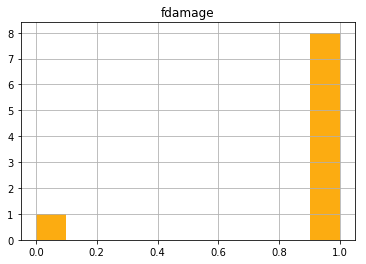

In [27]:
resDF[(resDF["SCC 2025"] > 180) & (resDF["policy"] == "robust_policy")].iloc[:,[1]].hist()